In [175]:
import duckdb
import pandas as pd
import statsmodels.formula.api as smf
from debugpy.common.util import evaluate
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Model evaluation functions

In [344]:
def evaluate_vifs(model):
    dataframe = pd.DataFrame(model.model.exog, columns=model.model.exog_names)
    
    # Define the predictor variables
    X = dataframe.select_dtypes(include=[np.number])
    
    # Add a constant to the model (intercept)
    X = add_constant(X)
    
    # Calculate VIF for each feature
    vif_df = pd.DataFrame()
    vif_df['Feature'] = X.columns
    vif_df['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print(vif_df.sort_values(by='VIF', ascending=False))

def test_model_assumptions(model):
    # Get residuals from your model
    residuals = model.resid
    
    X_design = model.model.exog
    bp_stat, bp_pvalue, _, _ = het_breuschpagan(model.resid, X_design)
    print(f'bp_stat: {bp_stat} | bp_pvalue: {bp_pvalue}')
    
    # Create diagnostic plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # 1. Histogram
    axes[0, 0].hist(residuals, bins=50, density=True, alpha=0.7, color='skyblue')
    axes[0, 0].set_title('Distribution of Residuals')
    axes[0, 0].set_xlabel('Residuals')
    
    # 2. Q-Q Plot
    stats.probplot(residuals, dist="norm", plot=axes[0, 1])
    axes[0, 1].set_title('Q-Q Plot (Normal)')
    
    # 3. Residuals vs Fitted
    fitted = model.fittedvalues
    axes[1, 0].scatter(fitted, residuals, alpha=0.6)
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Fitted Values')
    axes[1, 0].set_ylabel('Residuals')
    axes[1, 0].set_title('Residuals vs Fitted')
    
    # 4. Box plot
    axes[1, 1].boxplot(residuals)
    axes[1, 1].set_title('Box Plot of Residuals')
    
    plt.tight_layout()
    plt.show()
    
def generate_ind_var_str(target=None, data=None, exclusion_set=None, cat_var_set=None):
    feature_set = set(df.select_dtypes(include=[np.number]).columns)
    
    if exclusion_set:
        feature_set = feature_set - exclusion_set
    
    if cat_var_set:
        feature_set = feature_set | cat_var_set
    
    feature_str = ' + '.join(sorted(feature_set))
    return target + ' ~ ' + feature_str

# Load design matrix from gold schema

Transformations and preparation done in `dbt` project.

In [345]:
data_dir = '../data/ppp_loan_analysis.duckdb'
with duckdb.connect(data_dir) as conn:
    query = """
        SELECT * EXCLUDE (ppp_loan_amount, total_annual_wages)
        FROM gold.wage_adjusted_ppp_target
    """
    df = conn.execute(query).df()
    
df_clean = df.dropna()
assert len(df) == len(df_clean), 'Design matrix has missing values to remove'
display(df.describe())
df.head()

,yoy_job_change_pct,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,trump_share,accommodation_and_food_services_wage_share,accommodation_and_food_services_job_loc_quotient,...,retail_trade_wage_share,retail_trade_job_loc_quotient,transportation_and_warehousing_wage_share,transportation_and_warehousing_job_loc_quotient,unclassified_wage_share,unclassified_job_loc_quotient,utilities_wage_share,utilities_job_loc_quotient,wholesale_trade_wage_share,wholesale_trade_job_loc_quotient
count,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,...,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000,3102.000000
mean,0.004907,0.188088,0.846663,0.094348,0.015609,0.022171,0.098232,0.632285,0.039998,0.767231,...,0.099707,1.069855,0.036751,0.690538,0.000432,0.417953,0.008591,0.838736,0.049888,0.719981
std,0.046776,0.146931,0.159094,0.145067,0.029409,0.065549,0.139381,0.156691,0.044082,0.579438,...,0.045100,0.341253,0.049376,0.922990,0.001657,1.198862,0.021397,2.074849,0.054621,0.714270
min,-0.698834,0.002552,0.080279,0.000000,0.000000,0.000000,0.006478,0.040875,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.011261,0.117098,0.798526,0.008935,0.004771,0.004549,0.024585,0.544628,0.013833,0.360000,...,0.072031,0.880000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.006774,0.120000
50%,0.005441,0.151997,0.913437,0.026032,0.007463,0.007584,0.044783,0.663140,0.034584,0.820000,...,0.094869,1.080000,0.024795,0.490000,0.000000,0.000000,0.000000,0.000000,0.039935,0.605000
75%,0.022076,0.211278,0.954372,0.110353,0.014364,0.015041,0.101954,0.748781,0.051487,1.070000,...,0.123047,1.260000,0.050969,0.960000,0.000103,0.110000,0.009863,1.040000,0.068274,1.040000
max,0.387097,2.668559,0.990350,0.865932,0.433623,0.867643,0.963533,0.945848,0.550845,5.080000,...,0.394177,3.170000,0.688991,18.170000,0.055167,28.980000,0.436640,64.580000,0.544721,9.620000


,county,state,urbanicity,yoy_job_change_pct,wage_adjusted_ppp_loan_amount,white_pop_share,black_pop_share,asian_pop_share,native_pop_share,hispanic_share,...,retail_trade_wage_share,retail_trade_job_loc_quotient,transportation_and_warehousing_wage_share,transportation_and_warehousing_job_loc_quotient,unclassified_wage_share,unclassified_job_loc_quotient,utilities_wage_share,utilities_job_loc_quotient,wholesale_trade_wage_share,wholesale_trade_job_loc_quotient
0,Appomattox County,Virginia,urban,-0.016036,0.172092,0.786940,0.185469,0.003834,0.003520,0.018855,...,0.225276,1.94,0.000000,0.00,0.003127,2.79,0.000000,0.00,0.036170,0.47
1,Arlington County,Virginia,urban,0.026394,0.059148,0.750032,0.096782,0.109546,0.007769,0.156015,...,0.024007,0.49,0.064589,1.40,0.001434,1.60,0.011543,0.53,0.017317,0.22
2,Giles County,Virginia,urban,-0.025776,0.069858,0.962739,0.015969,0.005801,0.002990,0.018361,...,0.103267,1.30,0.019956,0.41,0.001315,1.50,0.000000,0.00,0.000000,0.00
3,Grayson County,Virginia,rural,0.121393,0.160522,0.924823,0.057428,0.002058,0.003601,0.038264,...,0.057088,0.51,0.015953,0.23,0.000000,0.00,0.000000,0.00,0.000000,0.00
4,Richmond County,Virginia,rural,-0.001100,0.170235,0.667516,0.296465,0.007093,0.006096,0.072925,...,0.074205,0.79,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.074327,1.13


## Evaluate correlations of numerical variables

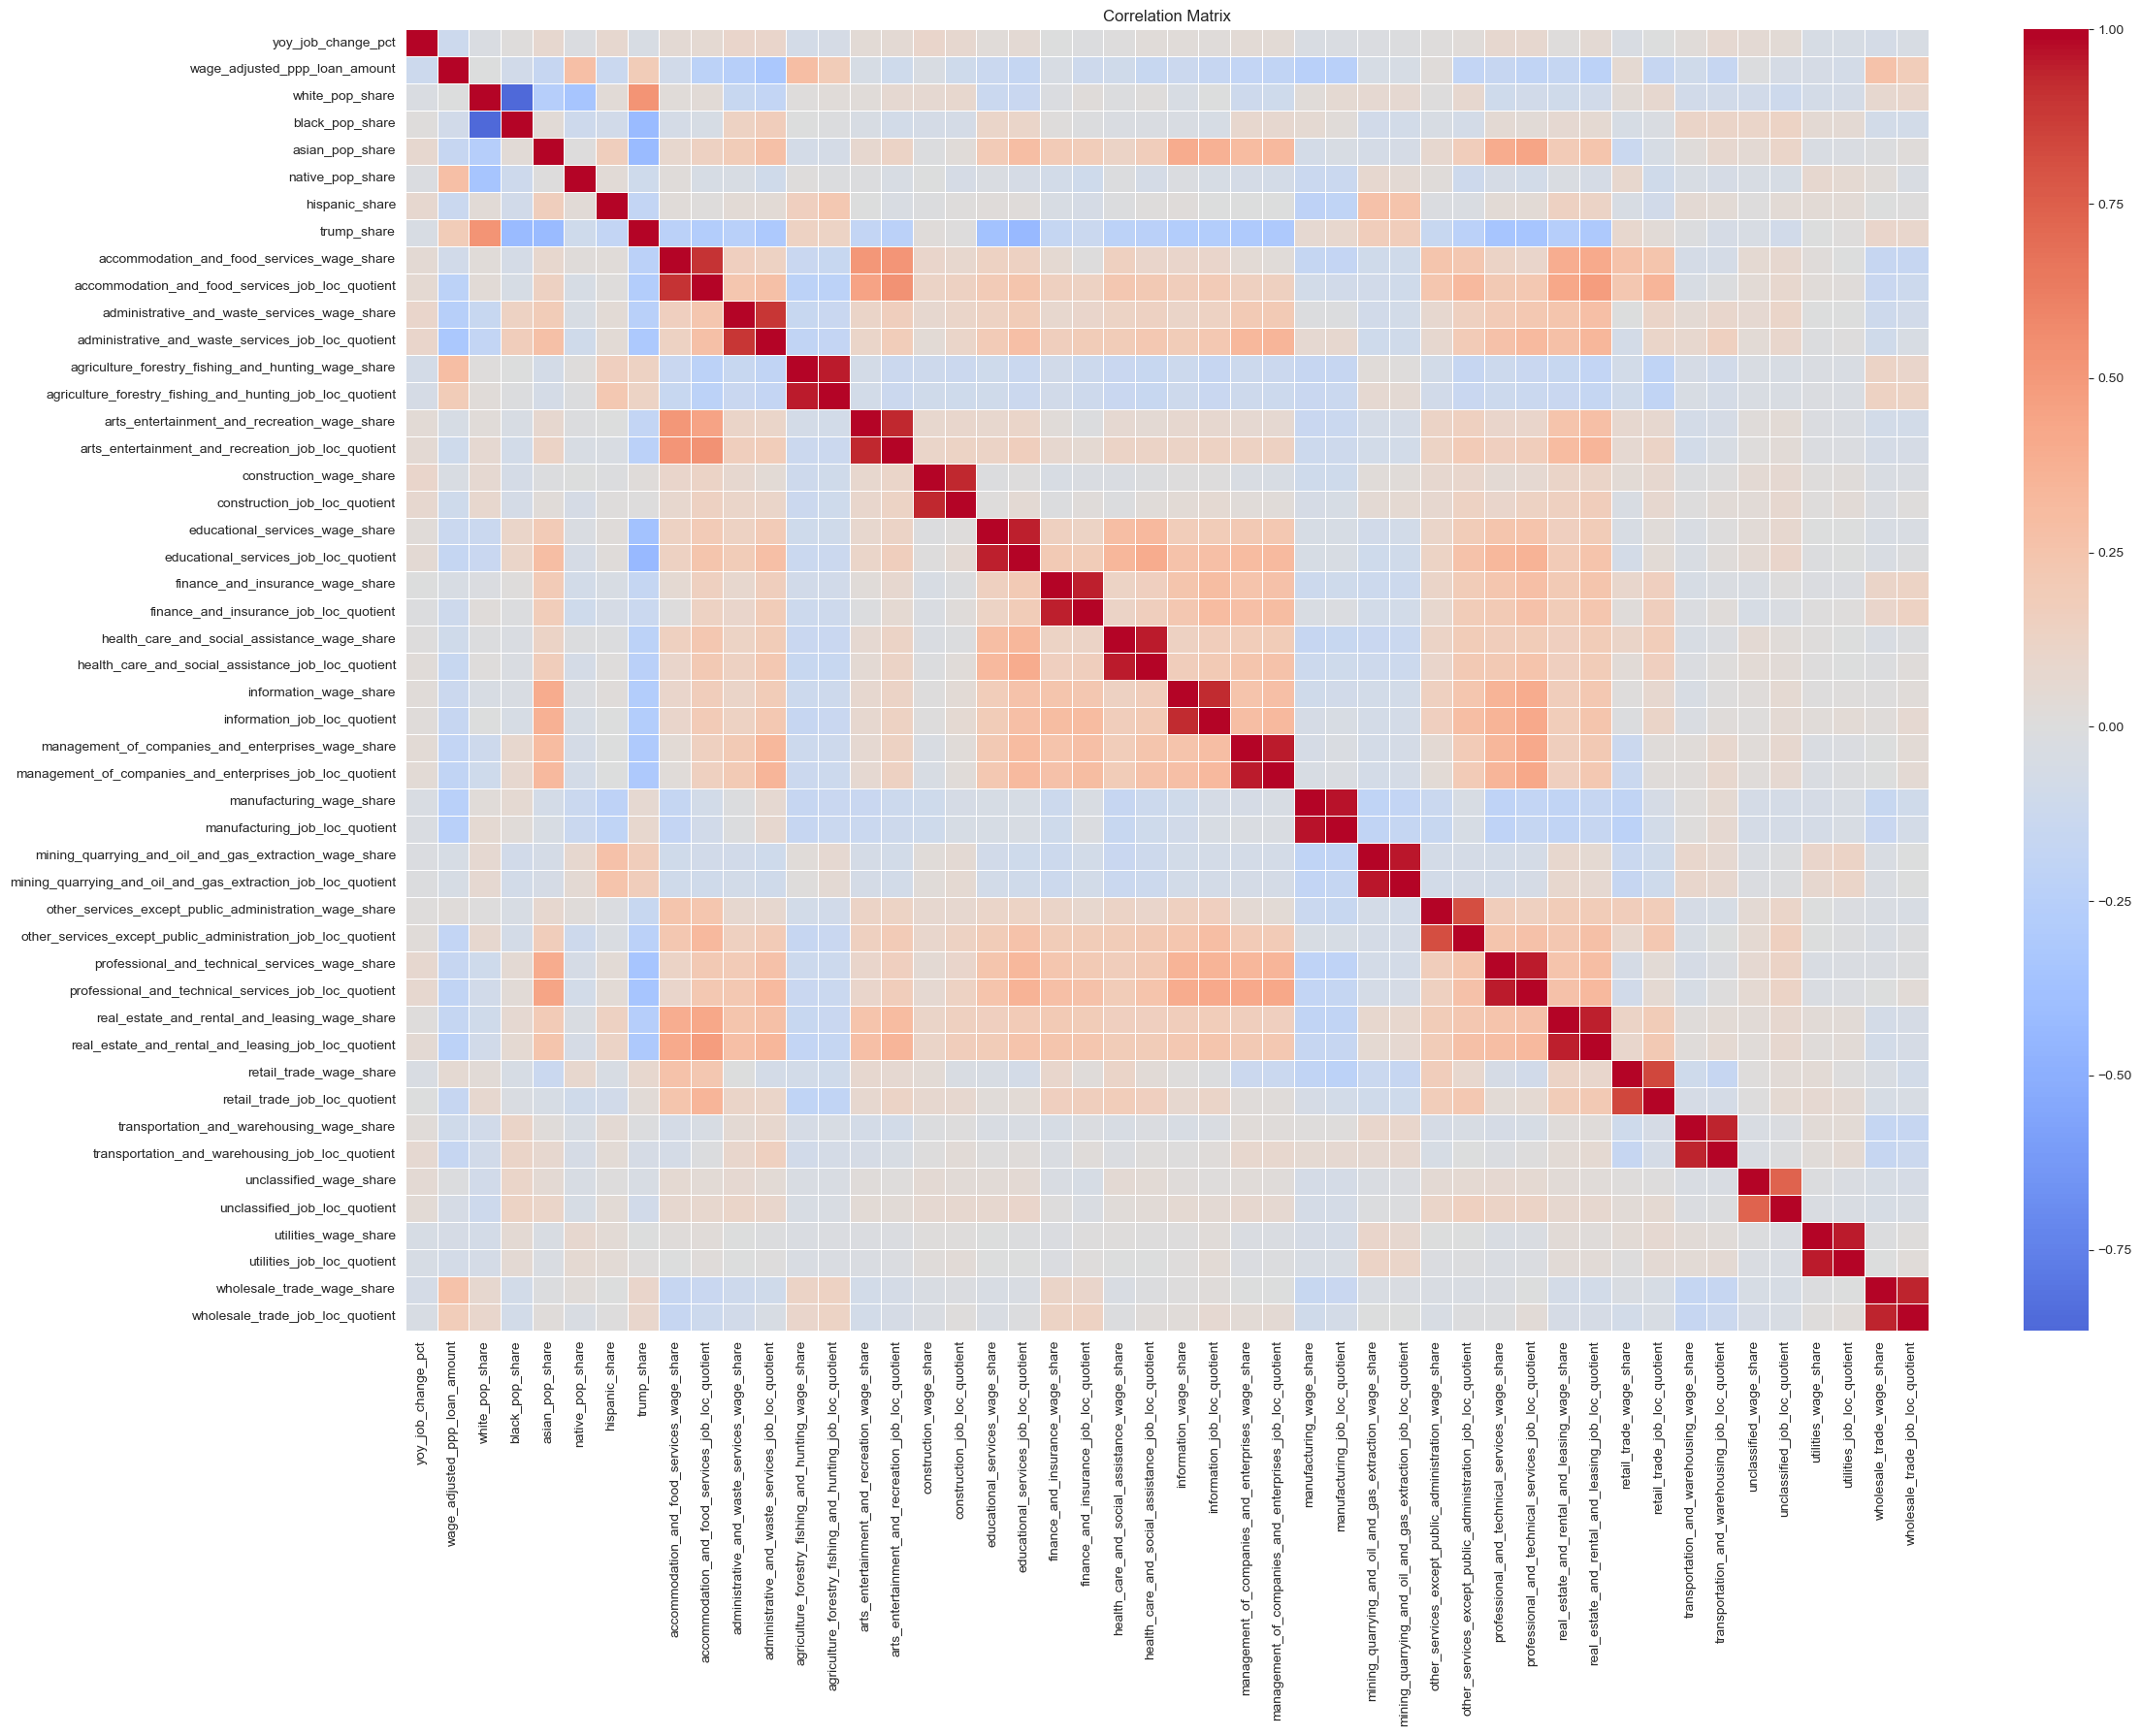

In [346]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
plt.figure(figsize=(24, 18))
sns.heatmap(correlation_matrix, 
            annot=False, 
            cmap='coolwarm', 
            center=0,
            square=False, 
            linewidths=0.5
)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

## Evaluate regression on all features

In [347]:
target = 'wage_adjusted_ppp_loan_amount'

base_model_spec = {
    'target': f'np.log({target})',
    'data': df,
    'exclusion_set': None,
    'cat_var_set': set(["C(urbanicity, Treatment(reference='urban'))"])
}

base_model_formula = generate_ind_var_str(**base_model_spec)
base_model = smf.ols(base_model_formula, data=df).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.792
Model:                                               OLS   Adj. R-squared:                  0.788
Method:                                    Least Squares   F-statistic:                     232.1
Date:                                   Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                                           18:48:54   Log-Likelihood:                -84.037
No. Observations:                                   3102   AIC:                             270.1
Df Residuals:                                       3051   BIC:                             578.1
Df Model:                                             50                                         
Covariance Type:                               nonrobust                                         
================================================================================================================================
                                                                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------
Intercept                                                       -1.8111      0.394     -4.595      0.000      -2.584      -1.038
C(urbanicity, Treatment(reference='urban'))[T.rural]             0.1209      0.017      7.206      0.000       0.088       0.154
C(urbanicity, Treatment(reference='urban'))[T.suburban]          0.0414      0.012      3.476      0.001       0.018       0.065
accommodation_and_food_services_job_loc_quotient                -0.0638      0.026     -2.480      0.013      -0.114      -0.013
accommodation_and_food_services_wage_share                       0.8839      0.324      2.731      0.006       0.249       1.518
administrative_and_waste_services_job_loc_quotient              -0.1773      0.028     -6.314      0.000      -0.232      -0.122
administrative_and_waste_services_wage_share                     1.2438      0.358      3.473      0.001       0.542       1.946
agriculture_forestry_fishing_and_hunting_job_loc_quotient        0.0232      0.003      6.993      0.000       0.017       0.030
agriculture_forestry_fishing_and_hunting_wage_share             -1.3564      0.261     -5.197      0.000      -1.868      -0.845
arts_entertainment_and_recreation_job_loc_quotient               0.0136      0.015      0.912      0.362      -0.016       0.043
arts_entertainment_and_recreation_wage_share                    -0.1243      0.866     -0.143      0.886      -1.823       1.575
asian_pop_share                                                 -1.8654      0.525     -3.551      0.000      -2.895      -0.835
black_pop_share                                                 -0.8184      0.398     -2.054      0.040      -1.600      -0.037
construction_job_loc_quotient                                   -0.1609      0.020     -8.248      0.000      -0.199      -0.123
construction_wage_share                                          2.4775      0.230     10.752      0.000       2.026       2.929
educational_services_job_loc_quotient                            0.0091      0.029      0.314      0.754      -0.048       0.066
educational_services_wage_share                                 -0.1851      1.018     -0.182      0.856      -2.182       1.812
finance_and_insurance_job_loc_quotient                          -0.0039      0.036     -0.109      0.913      -0.074       0.066
finance_and_insurance_wage_share                                 0.7310      0.424      1.723      0.085      -0.101       1.563
health_care_and_social_assistance_jo

## Model evaluation and quality checks

Evaluate multi-collinearity for potential removal of features and then evaluate model assumptions, in light of high Kurtosis, suggesting that residuals may not follow a normal distribution. 

### Inspect multi-collinearity

In [348]:
evaluate_vifs(base_model)

                                                         Feature          VIF
0                                                      Intercept  7667.149858
47                                               white_pop_share   198.389116
12                                               black_pop_share   164.809652
30                                              native_pop_share    40.195333
27                                      manufacturing_wage_share    16.931122
26                                manufacturing_job_loc_quotient    16.754562
19            health_care_and_social_assistance_job_loc_quotient    15.270006
20                  health_care_and_social_assistance_wage_share    14.556675
15                         educational_services_job_loc_quotient    14.354601
29        mining_quarrying_and_oil_and_gas_extraction_wage_share    14.290183
33          professional_and_technical_services_job_loc_quotient    14.280261
28  mining_quarrying_and_oil_and_gas_extraction_job_loc_quotient

bp_stat: 739.6709689226614 | bp_pvalue: 1.782553226146148e-123


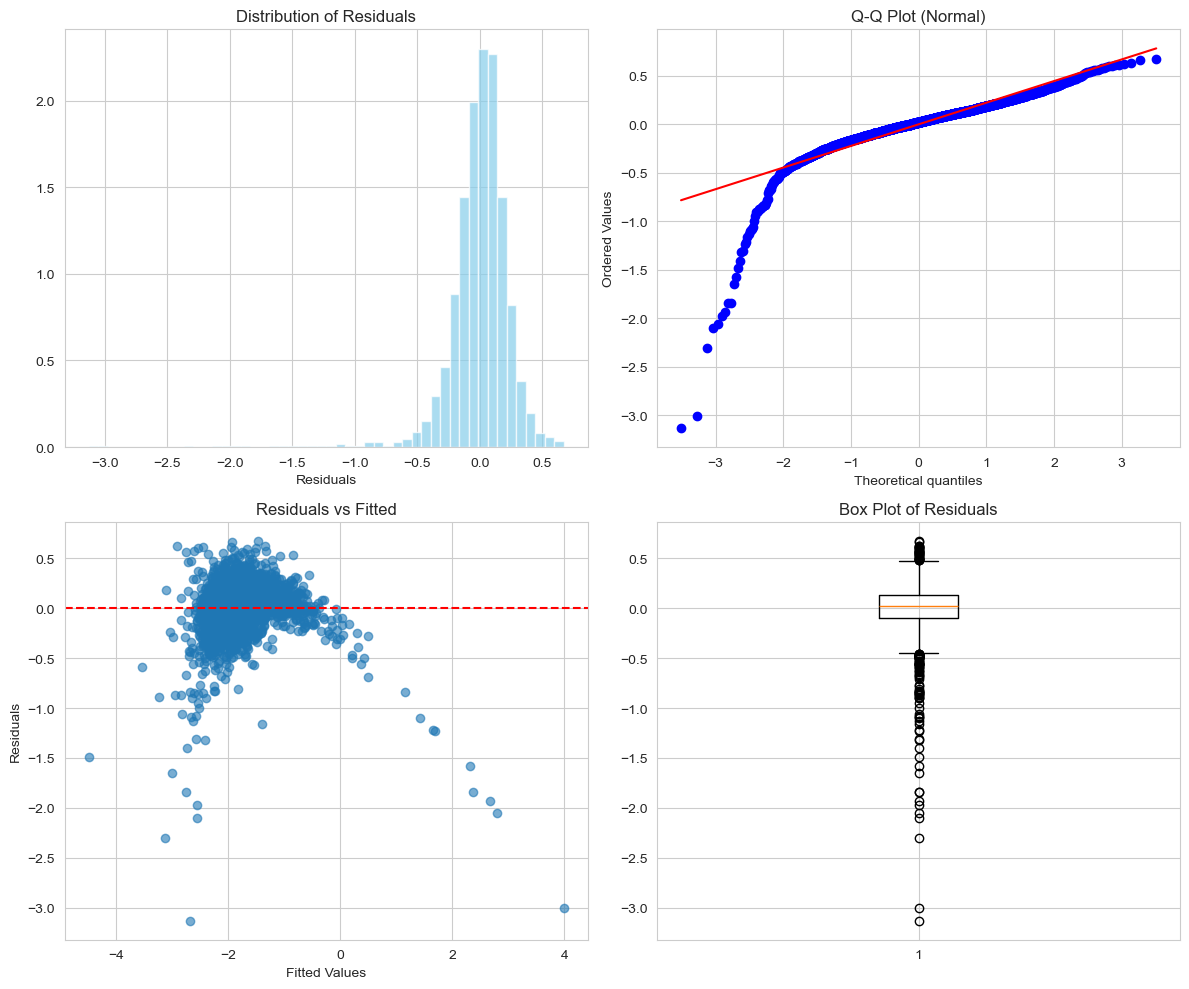

In [342]:
test_model_assumptions(base_model)

## Model interpretation

R^2 and Adj. R^2 show strong descriptive power, but explore additional features to better capture PPP lending trends.

### VIF
From p-values, feature `black_pop_share` can be removed, reinforced by VIF computation. Kurtosis of ~8.8 indicates heteroscedacity should be checked, to question linear regression assumptions before proceeding with default standard errors.

### Model assumptions
Breusch Pagan p value Q-Q and residuals v. fitted plots show model does not meet linear regression assumptions and that other standard errors should be explored, such as HC3.   

## Revise model from assumptions

In [297]:
formula = f"np.log(wage_adjusted_ppp_loan_amount) ~ {dep_feature_str}"
model2 = smf.ols(formula, data=df).fit(cov_type='HC3')
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.762
Model:                                               OLS   Adj. R-squared:                  0.760
Method:                                    Least Squares   F-statistic:                     168.9
Date:                                   Wed, 23 Jul 2025   Prob (F-statistic):               0.00
Time:                                           17:15:38   Log-Likelihood:                -289.00
No. Observations:                                   3102   AIC:                             636.0
Df Residuals:                                       3073   BIC:                             811.2
Df Model:                                             28                                         
Covariance Type:                                     HC3                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -2.6341      0.075    -35.128      0.000      -2.781      -2.487
C(urbanicity, Treatment(reference='urban'))[T.rural]        0.1531      0.031      4.889      0.000       0.092       0.214
C(urbanicity, Treatment(reference='urban'))[T.suburban]     0.0666      0.013      4.960      0.000       0.040       0.093
wage_adjusted_ppp_loan_amount                               2.6694      0.262     10.203      0.000       2.157       3.182
white_pop_share                                            -0.0588      0.041     -1.443      0.149      -0.139       0.021
asian_pop_share                                            -0.9916      0.331     -2.999      0.003      -1.640      -0.344
native_pop_share                                           -0.5546      0.213     -2.607      0.009      -0.972      -0.138
hispanic_share                                             -0.2041      0.065     -3.153      0.002      -0.331      -0.077
trump_share                                                -0.0197      0.053     -0.372      0.710      -0.123       0.084
accommodation_and_food_services_wage_share                  0.2338      0.134      1.746      0.081      -0.029       0.496
administrative_and_waste_services_wage_share               -0.9563      0.232     -4.124      0.000      -1.411      -0.502
agriculture_forestry_fishing_and_hunting_wage_share         0.4485      0.178      2.520      0.012       0.100       0.797
arts_entertainment_and_recreation_wage_share                0.4197      0.469      0.895      0.371      -0.499       1.338
construction_wage_share                                     0.7282      0.270      2.698      0.007       0.199       1.257
educational_services_wage_share                            -0.0188      0.290     -0.065      0.948      -0.588       0.551
finance_and_insurance_wage_share                            0.6180      0.171      3.605      0.000       0.282       0.954
health_care_and_social_assistance_wage_share                0.0755      0.062      1.209      0.227      -0.047       0.198
information_wage_share                                      0.2086      0.355      0.587      0.557      -0.488       0.905
management_of_companies_and_enterprises_wage_share         -0.9656      0.271     -3.568      0.000      -1.496      -0.435
manufacturing_wage_share                                   -0.0423      0.076     -0.553      0.580      -0.192       0.107
mining_quarrying_and_o

### Evaluate new model

                                                    Feature        VIF
0                                                 Intercept  82.842279
8                                               trump_share   2.333142
1      C(urbanicity, Treatment(reference='urban'))[T.rural]   2.012877
4                                           white_pop_share   1.892092
9                accommodation_and_food_services_wage_share   1.730444
19                                 manufacturing_wage_share   1.699317
3                             wage_adjusted_ppp_loan_amount   1.638425
2   C(urbanicity, Treatment(reference='urban'))[T.suburban]   1.597958
5                                           asian_pop_share   1.569005
22           professional_and_technical_services_wage_share   1.550921
23            real_estate_and_rental_and_leasing_wage_share   1.450284
12             arts_entertainment_and_recreation_wage_share   1.406300
7                                            hispanic_share   1.398717
20   m

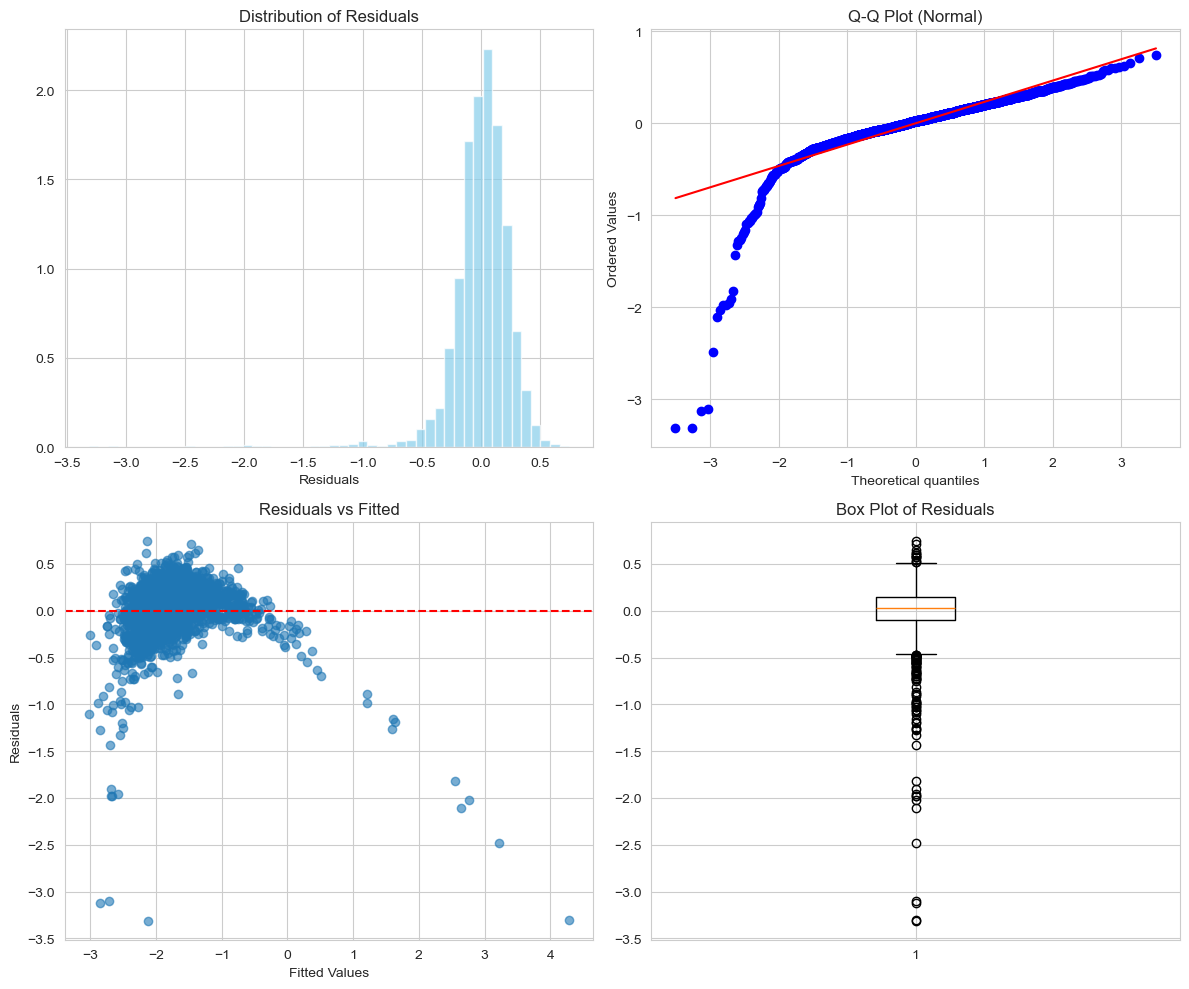

In [298]:
evaluate_vifs(model2)
test_model_assumptions(model2)

In [174]:
working_summary = model2.summary()
working_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OLS Regression Results                                     
=================================================================================================
Dep. Variable:     np.log(wage_adjusted_ppp_loan_amount)   R-squared:                       0.225
Model:                                               OLS   Adj. R-squared:                  0.223
Method:                                    Least Squares   F-statistic:                     88.91
Date:                                   Tue, 22 Jul 2025   Prob (F-statistic):          2.36e-118
Time:                                           13:23:06   Log-Likelihood:                -2123.4
No. Observations:                                   3102   AIC:                             4263.
Df Residuals:                                       3094   BIC:                             4311.
Df Model:                                              7                                         
Covariance Type:                                     HC3                                         
===========================================================================================================================
                                                              coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------
Intercept                                                  -1.8847      0.071    -26.569      0.000      -2.024      -1.746
C(urbanicity, Treatment(reference='urban'))[T.rural]        0.5462      0.033     16.581      0.000       0.482       0.611
C(urbanicity, Treatment(reference='urban'))[T.suburban]     0.0782      0.020      3.925      0.000       0.039       0.117
yoy_job_change_pct                                         -0.8090      0.342     -2.365      0.018      -1.480      -0.138
white_pop_share                                            -0.1997      0.073     -2.734      0.006      -0.343      -0.057
asian_pop_share                                            -2.2761      0.509     -4.473      0.000      -3.274      -1.279
hispanic_share                                             -0.3765      0.072     -5.242      0.000      -0.517      -0.236
trump_share                                                 0.2453      0.076      3.208      0.001       0.095       0.395
==============================================================================
Omnibus:                      840.889   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9311.174
Skew:                          -0.963   Prob(JB):                         0.00
Kurtosis:                      11.266   Cond. No.                         60.2
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

# Conclusion

## Summary
Urbanicity, racial makeup and 2016 election results held modest explanatory power for the distribution of Paycheck Protection Program loans by county, with an adjusted R^2 of `0.223`. The PPP amounts were adjusted by the size of local payrolls, taken from QCEW baselines for 2019.

The model showed rural areas were strongly favored to receive more wage-adjusted PPP dollars, in addition to some concerning trends by racial makeup that indicate concern of bias within the program. 

### Bias concerns
Within this limited explanation, the strongest association raises concerns about bias in the program and aligns, troublingly, with anti-Asian bias in response to the pandemic that began in Wuhan, China. This assocation warrants further investigation to evaluate additional county-level characteristics or to view this relationship in the context of a model with greater explanatory power.

The model also shows that higher percentages of Hispanic residents were associated with lower amounts of wage-adjusted PPP loan amounts.

Also of concern, the vote share for President Donald Trump also showed a relationship to higher totals of wage-adjusted PPP loans, suggesting that political favoritism may have affected use of the program.  